In [102]:
import torch
import pandas as pd
import torchtext
from torchtext import data
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import helpers
import importlib
importlib.reload(helpers)

<module 'helpers' from 'c:\\Users\\Yousef\\source\\repos\\Sentiment-Analysis\\helpers.py'>

Uncomment the line below to download the spaCy tokenizer if not already done so

In [103]:
#!python -m spacy download en

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torchtext.__version__)
print(torch.__version__)
print(device)
torch.backends.cudnn.deterministic = True

# constants
FILE_NAME = "training.1600000.processed.noemoticon.csv"
SUBSET_FILE_NAME = "data.csv"
N = 80000
SEED = 1
SPLIT_RATIO = [0.7, 0.15, 0.15]
MAX_VOCAB_SIZE = 30000
GLOVE_VECTORS = "glove.6B.100d"
GLOVE_DIM = 100
BATCH_SIZE = 128
FIXED_LENGTH = 32
PT_PATH = "saves"
EPOCHS=20
LR = 1e-4

torch.manual_seed(SEED)

0.6.0
2.1.1+cu118
cuda


## Data Preprocessing
Load in the subset created in the `RNN-analysis` notebook.

In [105]:
subset_df = pd.read_csv(SUBSET_FILE_NAME, header=None, engine="python", encoding="latin-1")
subset_df.head()

,0,1,2,3,4,5
0,0,2190584004,Tue Jun 16 03:08:48 PDT 2009,NO_QUERY,Vicki_Gee,i miss nikki nu nu already shes always there ...
1,0,1881451988,Fri May 22 04:42:15 PDT 2009,NO_QUERY,PatCashin,So I had a dream last night. I remember a sig...
2,0,2058252964,Sat Jun 06 14:34:17 PDT 2009,NO_QUERY,deelectable,@girlyghost ohh poor sickly you (((hugs)) ho...
3,0,2237307600,Fri Jun 19 05:34:22 PDT 2009,NO_QUERY,justinekepa,it is raining again
4,0,2224301193,Thu Jun 18 09:20:06 PDT 2009,NO_QUERY,cmatt007,@MissKeriBaby wish I was in LA right now


### Creating the Dataset
First, declare the text and label fields. By setting `fix_length`, we will be padding all sequences to it. We will also be using `batch_first=True` to match what the `Conv2d` layers expect.

In [106]:
TEXT = data.Field(tokenize='spacy', lower=True, fix_length=FIXED_LENGTH, batch_first=True)
LABEL = data.LabelField(dtype=torch.float, batch_first=True)

fields = [
    ('label', LABEL), 
    ('id', None),
    ('date', None),
    ('query', None),
    ('name', None), 
    ('text', TEXT),
    ('category',None)
]

dataset = data.TabularDataset(
    path=SUBSET_FILE_NAME,
    format="CSV",
    fields=fields,
    skip_header=False
)

In [107]:
# Split into train, test, validation sets
train_dataset, test_dataset, validation_dataset = dataset.split(split_ratio=SPLIT_RATIO)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")

Train dataset size: 56000
Test dataset size: 12000
Validation dataset size: 12000


### Building the Vocab
The vocab will be built using pre-train [GloVe](https://nlp.stanford.edu/projects/glove/) embeddings. It is also important to note that the vocab should only be built using the test dataset. The `unk_init` parameter specifies the initialization method for the vectors of out-of-vocabulary (OOV) tokens. It will be set to use a normal distribution for the initialization of OOV token vectors.

In [108]:
TEXT.build_vocab(
    train_dataset, 
    max_size = MAX_VOCAB_SIZE,
    vectors = GLOVE_VECTORS,
    unk_init = torch.Tensor.normal_
)

LABEL.build_vocab(train_dataset)

### Bucket Iterators
Text sequences will be grouped in batches based on similar lengths. Text sequences in a batch will all have the same length by applying padding. By batching sequences of similar lengths, minimal padding will be applied in each batch

In [109]:
train_iterator, validation_iterator, test_iterator = data.BucketIterator.splits(
    (train_dataset, validation_dataset, test_dataset),
    device = device,
    batch_size = BATCH_SIZE,
    sort_key = lambda sample: len(sample.text),
    sort_within_batch = True
)

### What does our data look like?

In [110]:
for batch in train_iterator:
    sequences, labels = batch.text, batch.label
    print("Length tensor shape:", sequences.shape)
    print("Text tensor shape:", sequences.shape)
    print("Labels tensor shape:", labels.shape)
    text_words = [train_iterator.dataset.fields['text'].vocab.itos[idx] for idx in sequences[0].tolist()]
    print("Text words:", text_words)
    print("Labels:", labels)
    break

Length tensor shape: torch.Size([128, 32])
Text tensor shape: torch.Size([128, 32])
Labels tensor shape: torch.Size([128])
Text words: ['<unk>', 'dang', 'it', ' ', 'i', "'ll", 'be', 'there', 'the', '25', '-', '26th', '.', 'i', 'ca', "n't", 'believe', 'we', 'always', 'miss', 'eachother', '!', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
Labels: tensor([1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
        1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
        1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0.,
        1., 0.], device='cuda:0')


## Simple CNN Model

In [111]:
import CNN
importlib.reload(CNN)

padding_idx = padding_idx=TEXT.vocab.stoi[TEXT.pad_token]
unknown_idx = padding_idx=TEXT.vocab.stoi[TEXT.unk_token]

model = CNN.Classifier(
    input_dim=len(TEXT.vocab), 
    embedding_dim=GLOVE_DIM, 
    num_filters=20,
    filter_sizes=[3],
    output_dim=1,
    dropout_probability=0.5,
    padding_idx=padding_idx,
    name="simple_CNN_model"
)

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

model.embedding.weight.data[padding_idx] = torch.zeros(GLOVE_DIM)
model.embedding.weight.data[unknown_idx] = torch.zeros(GLOVE_DIM)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

### Train and Validation Loops

In [112]:
def train(model, iterator, optimizer, criterion):
    total_loss = 0.0
    total_accuracy = 0.0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        sequences = batch.text
        predictions = model(sequences).squeeze(1)
        loss = criterion(predictions, batch.label)
        accuracy = helpers.get_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_accuracy += accuracy.item()
    return total_loss / len(iterator), total_accuracy / len(iterator)

def evaluate(model, iterator, criterion):
    total_loss = 0.0
    total_accuracy = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text = batch.text
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, batch.label)
            accuracy = helpers.get_accuracy(predictions, batch.label)
            total_loss += loss.item()
            total_accuracy += accuracy.item()
    return total_loss / len(iterator), total_accuracy / len(iterator)

In [113]:
train_accuracies, validation_accuraies = helpers.train_loop(
    train_fn=train,
    evaluate_fn=evaluate,
    model=model,
    train_iterator=train_iterator,
    validation_iterator=validation_iterator,
    optimizer=optimizer,
    criterion=criterion,
    epochs=EPOCHS,
    check_point_path=PT_PATH
)

Epoch 1 | Elapsed: 0:00:27.273964
Train Loss 0.71 | Train Accuracy: 51.59%
Validation Loss 0.68 | Validation Accuracy: 58.59%

Epoch 2 | Elapsed: 0:00:26.937933
Train Loss 0.69 | Train Accuracy: 54.57%
Validation Loss 0.68 | Validation Accuracy: 61.38%

Epoch 3 | Elapsed: 0:00:27.315954
Train Loss 0.68 | Train Accuracy: 57.82%
Validation Loss 0.67 | Validation Accuracy: 64.03%

Epoch 4 | Elapsed: 0:00:27.410123
Train Loss 0.67 | Train Accuracy: 59.42%
Validation Loss 0.66 | Validation Accuracy: 65.09%

Epoch 5 | Elapsed: 0:00:27.356755
Train Loss 0.66 | Train Accuracy: 61.09%
Validation Loss 0.64 | Validation Accuracy: 66.46%

Epoch 6 | Elapsed: 0:00:27.405789
Train Loss 0.65 | Train Accuracy: 62.92%
Validation Loss 0.63 | Validation Accuracy: 67.94%

Epoch 7 | Elapsed: 0:00:27.401476
Train Loss 0.64 | Train Accuracy: 64.00%
Validation Loss 0.62 | Validation Accuracy: 69.13%

Epoch 8 | Elapsed: 0:00:27.452055
Train Loss 0.63 | Train Accuracy: 65.45%
Validation Loss 0.6 | Validation Acc

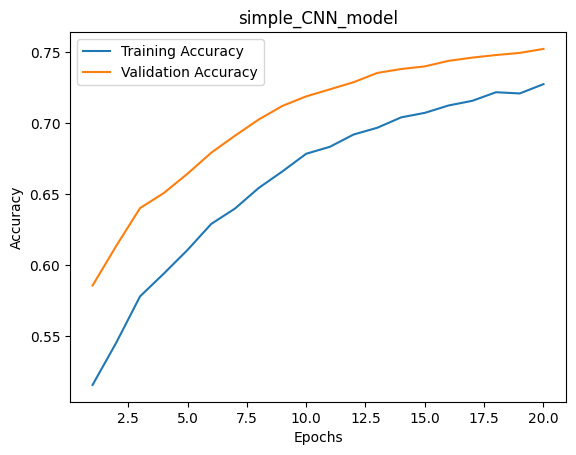

In [114]:
helpers.plot_learning_curves(train_accuracies, validation_accuraies, model.name)

## Multi-Layered CNN Model

In [115]:
padding_idx = padding_idx=TEXT.vocab.stoi[TEXT.pad_token]
unknown_idx = padding_idx=TEXT.vocab.stoi[TEXT.unk_token]

model2 = CNN.Classifier(
    input_dim=len(TEXT.vocab), 
    embedding_dim=GLOVE_DIM, 
    num_filters=50,
    filter_sizes=[3, 4, 5, 6],
    output_dim=1,
    dropout_probability=0.5,
    padding_idx=padding_idx,
    name="multi_layered_CNN_model"
)

pretrained_embeddings = TEXT.vocab.vectors
model2.embedding.weight.data.copy_(pretrained_embeddings)

model2.embedding.weight.data[padding_idx] = torch.zeros(GLOVE_DIM)
model2.embedding.weight.data[unknown_idx] = torch.zeros(GLOVE_DIM)

optimizer = optim.Adam(model2.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()

model2 = model2.to(device)
criterion = criterion.to(device)

In [116]:
train_accuracies, validation_accuraies = helpers.train_loop(
    train_fn=train,
    evaluate_fn=evaluate,
    model=model2,
    train_iterator=train_iterator,
    validation_iterator=validation_iterator,
    optimizer=optimizer,
    criterion=criterion,
    epochs=EPOCHS,
    check_point_path=PT_PATH
)

Epoch 1 | Elapsed: 0:00:22.760077
Train Loss 0.72 | Train Accuracy: 52.23%
Validation Loss 0.67 | Validation Accuracy: 62.63%

Epoch 2 | Elapsed: 0:00:22.431223
Train Loss 0.67 | Train Accuracy: 57.98%
Validation Loss 0.64 | Validation Accuracy: 65.81%

Epoch 3 | Elapsed: 0:00:22.493174
Train Loss 0.65 | Train Accuracy: 62.12%
Validation Loss 0.62 | Validation Accuracy: 68.40%

Epoch 4 | Elapsed: 0:00:22.417181
Train Loss 0.62 | Train Accuracy: 65.29%
Validation Loss 0.59 | Validation Accuracy: 70.01%

Epoch 5 | Elapsed: 0:00:22.404487
Train Loss 0.61 | Train Accuracy: 67.10%
Validation Loss 0.57 | Validation Accuracy: 71.44%

Epoch 6 | Elapsed: 0:00:22.354676
Train Loss 0.59 | Train Accuracy: 68.83%
Validation Loss 0.56 | Validation Accuracy: 72.30%

Epoch 7 | Elapsed: 0:00:22.367764
Train Loss 0.57 | Train Accuracy: 70.05%
Validation Loss 0.54 | Validation Accuracy: 73.37%

Epoch 8 | Elapsed: 0:00:22.354252
Train Loss 0.56 | Train Accuracy: 71.23%
Validation Loss 0.53 | Validation Ac

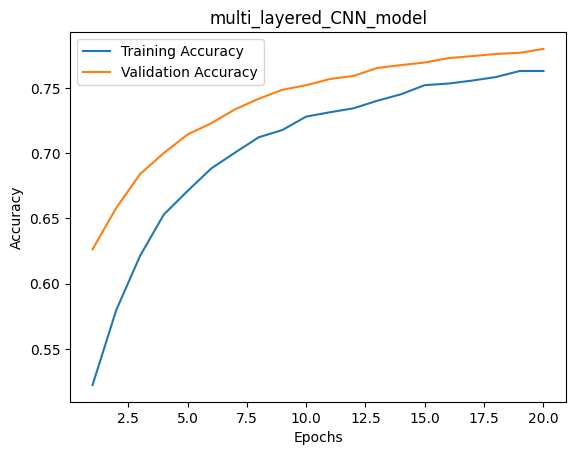

In [117]:
helpers.plot_learning_curves(train_accuracies, validation_accuraies, model2.name)

# Compare the models

In [118]:
a, b = helpers.compare_best(PT_PATH, model, model2, evaluate, test_iterator, criterion)
print(f"Model {model.name} test accuracy: {a}")
print(f"Model {model2.name} test accuracy: {b}")

Model simple_CNN_model test accuracy: 0.7568705677986145
Model multi_layered_CNN_model test accuracy: 0.7830230498567541
